In [1]:
from KMDHierarchicalClustering.KMDAlgo import KMDClustering
from KMDHierarchicalClustering import cluster_scoring
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
import time 
import hdbscan
import random
import os
%matplotlib inline

This notbook evaluates our method’s performance on a standard set of simulated datasets,
provided by the python package scikit-learn to demonstrate the strengths and weaknesses of standard generic 
clustering algorithms vs KMD algorithem. The scikit-learn datasets consist of five two-dimensional clustering problems 
(nested circles, half moons, globular clusters, and anisotropic clusters)

In [2]:
t = time.time()

In [3]:
### generate datasets ###
np.random.seed(1)
random.seed(1)
n_samples = 1000

# nested circle data
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.3,
                                      noise=0.05)
# moons dataset
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1, 2.5, 0.5], random_state=random_state)


In [4]:
# Set up cluster parameters
# note that recomended k_scan_range is 1 to 100, the range was reduced to save time 
default_base = {
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'min_cluster_size': 'compute',
                }

dataset_params_list = [
    (noisy_circles, {'eps': 0.15,'n_clusters': 2, 'k':'compute', 'k_scan_range' : [5]}),
    (noisy_moons, {'eps': 0.15,'n_clusters': 2, 'k':'compute', 'k_scan_range' : [99]}),
    (varied, {'eps': .18, 'n_neighbors': 2,'min_samples': 5, 'k':'compute', 'k_scan_range' :[36]}),
    (aniso, {'eps': .15, 'n_neighbors': 2,'min_samples': 20, 'k':'compute', 'k_scan_range' : [56]}),
]

/Users/hkariti/.virtualenvs/KMDHierarchicalClustering-omyl/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Default minimum cluster size is : 50 calculated by: max(2,#objects /(10*#clusters)) 
In general, minimum cluster size can be chosen to be slightly smaller than the size of the smallest expected cluster
calculating k=5


/Users/hkariti/repo/technion/KMDHierarchicalClustering/KMDHierarchicalClustering/predict_clust_label.py:241: RuntimeWarning: invalid value encountered in divide
  norm_sil = (_sil - _sil.min()) / _sil.ptp()
/Users/hkariti/.virtualenvs/KMDHierarchicalClustering-omyl/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Predicted k is : 5
Default minimum cluster size is : 50 calculated by: max(2,#objects /(10*#clusters)) 
In general, minimum cluster size can be chosen to be slightly smaller than the size of the smallest expected cluster
calculating k=99


/Users/hkariti/repo/technion/KMDHierarchicalClustering/KMDHierarchicalClustering/predict_clust_label.py:241: RuntimeWarning: invalid value encountered in divide
  norm_sil = (_sil - _sil.min()) / _sil.ptp()


Predicted k is : 99
Default minimum cluster size is : 33 calculated by: max(2,#objects /(10*#clusters)) 
In general, minimum cluster size can be chosen to be slightly smaller than the size of the smallest expected cluster
calculating k=36


/Users/hkariti/repo/technion/KMDHierarchicalClustering/KMDHierarchicalClustering/predict_clust_label.py:241: RuntimeWarning: invalid value encountered in divide
  norm_sil = (_sil - _sil.min()) / _sil.ptp()


Predicted k is : 36
Default minimum cluster size is : 33 calculated by: max(2,#objects /(10*#clusters)) 
In general, minimum cluster size can be chosen to be slightly smaller than the size of the smallest expected cluster
calculating k=56


/Users/hkariti/repo/technion/KMDHierarchicalClustering/KMDHierarchicalClustering/predict_clust_label.py:241: RuntimeWarning: invalid value encountered in divide
  norm_sil = (_sil - _sil.min()) / _sil.ptp()


Predicted k is : 56


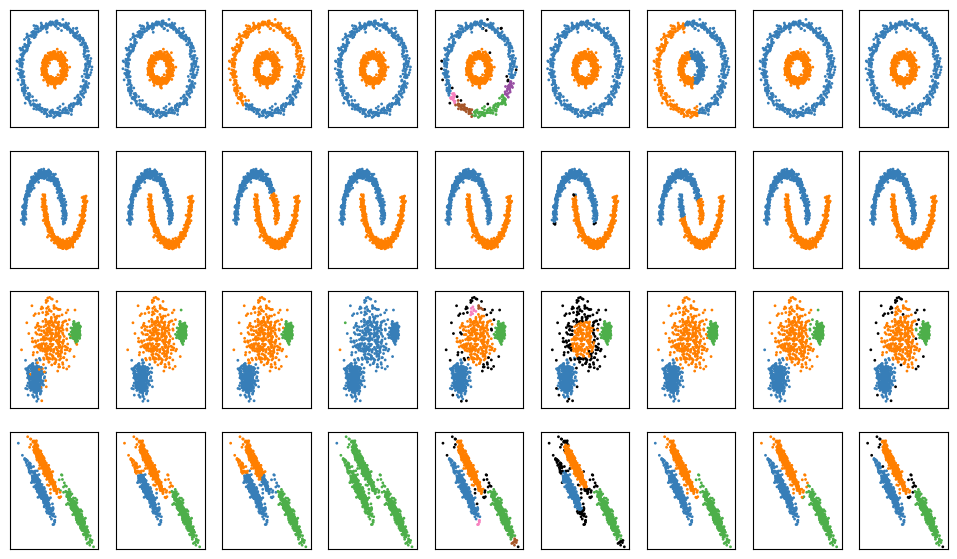

In [5]:
# Iterate on all datasets 
f =plt.figure(figsize=(12.1, 7)) #, dpi=300)
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(dataset_params_list):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # Create cluster objects
    HAC_single = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='single')
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    hbscan = hdbscan.HDBSCAN(min_cluster_size=int(n_samples/(10*params['n_clusters'])))# minimum size matching kmd 'compute' method 
    average_linkage = cluster.AgglomerativeClustering(linkage="average", n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')
    kmd = KMDClustering(k=params['k'], n_clusters = params['n_clusters'], min_cluster_size = params['min_cluster_size'], certainty = 0.5, k_scan_range = params['k_scan_range'])
    #kmd_core = KMDClustering(k=params['k'], n_clusters = params['n_clusters'], min_cluster_size = params['min_cluster_size'], certainty = 1, k_scan_range = params['k_scan_range'])
    
    clustering_algorithms = (
        ('True labels',0),
        ('Spectral', spectral),
        ('Avg ', average_linkage),
        ('Single ', HAC_single),
        ('DBSCAN', dbscan),
        ('HDBSCAN', hbscan),
        ('Gaussian Mix', gmm),
        ('KMD ' ,kmd),
        ('KMD(core)', kmd)
    )
    
        # cluster each dataset 
    for name, algorithm in clustering_algorithms:
        if algorithm != 0:
            if name != 'KMD(core)':
                algorithm.fit(X)
            else:
                algorithm.certainty = 1
            if hasattr(algorithm, 'labels_'):
                y_pred = algorithm.labels_.astype(int)
            else:
                y_pred = algorithm.predict(X)
            _, y_pred = cluster_scoring.hungarian_acc(y, y_pred)
        elif name == 'True labels':
            y_pred= y

        
        core_idx = y_pred != -1
        y_pred_eval = y_pred[core_idx]
        y_eval = y[core_idx]

        plt.subplot(len(dataset_params_list), len(clustering_algorithms) , plot_num)

        #if i_dataset == 0:
        #    plt.title(name, size=8)
            
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=1, color=colors[y_pred])
        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1
plt.show()

In [6]:
print('Total running time on toy dataset: '+str(time.time()-t)+ ' seconds')

Total running time on toy dataset: 27.46198296546936 seconds
